In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from scipy import special
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import h5py
from matplotlib.ticker import MaxNLocator




def read_data(model_name, relax_time, time_step, total_time=100):
    line_width = 5e3 #The width of the line (a mesh with infinite points would need 0 width)
    
    #construct path string
    path = "../"+str(model_name)+"/Analysis/"+str(total_time)+"yrs_relax="+str(relax_time)+"_"+str(time_step)+".csv"
    
    model_output_df = pd.read_csv(path)
    
    #select rows from the dataframe where y is less then the specified width
    x_line = model_output_df.loc[(model_output_df['Points_1'] < line_width) & (model_output_df['Points_1'] > 0)]
    
    x = np.asarray(x_line['Points_0'])
    disp_x = np.asarray(x_line['displacement_0'])
    disp_y = np.asarray(x_line['displacement_1'])
    disp_z = np.asarray(x_line['displacement_2'])
    vel_x = np.asarray(x_line['velocity_0'])
    vel_y = np.asarray(x_line['velocity_1'])
    vel_z = np.asarray(x_line['velocity_2'])
    
    return (x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z)

def read_h5(model_name, relax_time, time_step, total_time=100, theta=None):
    
    #dictionary to be updated with the name of the file and the 'model name' given
    file_names = {"ViscoelasticSandwich/10km": "ViscoelasticSandwich",
                  "ViscoelasticSandwich/15km": "ViscoelasticSandwich", 
                  "OneLayerViscoelastic": "OneLayerViscoelastic",
                  "ViscoelasticLayer": "ViscoelasticLayer",
                  "SMB/NoCyl": "SMB_noCyl", 
                  "ViscoelasticCylinder/35km": "ViscoelasticCylinder",
                  "ViscoelasticCylinder/50km": "ViscoelasticCylinder",
                  "ViscoelasticCylinderSlice/35km": "ViscoelasticCylinderSlice",
                  "ViscoelasticCylinderSlice/50km": "ViscoelasticCylinderSlice",
                  "TimeDependentPressure/10yrSawtooth/ViscoelasticLayer": "ViscoelasticLayer",
                  "TimeDependentPressure/10yrSawtooth/ViscoelasticSandwich": "ViscoelasticSandwich", 
                  "TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/35km": "ViscoelasticCylinderSliceTD",
                  "TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/50km": "ViscoelasticCylinderSliceTD",
                  "TimeDependentPressure/10yrSawtooth/SMB/NoCyl": "SMB_noCyl"}
    
    line_width = 10e3 #The width of the line (a mesh with infinite points would need 0 width)
    mesh_width = 150e3 #width of mesh from 0 to edge
    
    #get the file path
    path = "../"+str(model_name)+"/output/" + file_names[model_name] + "-groundsurf-100_"+str(relax_time)+"_yr_relax.h5" 
    
    #prepare lists for getting data from hdf5 files
    with h5py.File(path, "r") as f:
            
        #print(f.keys())
        #Get the HDF5 groups
        group_geometry = f['geometry']
        group_vert_fields = f['vertex_fields']
        
        points = group_geometry['vertices'] #shape: point_num, xyz
        displacements = group_vert_fields['displacement'] #shape: timestep, point_num, xyz
        velocities = group_vert_fields['velocity'] #shape: timestep, point_num, xyz
       
        #allow a theta for an arbitrary line on the model
        #theta is in degrees!
#         if theta == None:
#             x_line_indices = np.where((points[:,1] > 0) & (points[:,1] < line_width)) #get indices for the xline
#         else:
#             x_line_indices = np.where((points[:,1] - points[:,0]*np.tan(theta) > 0) & (points[:,1] - points[:,0]*np.tan(theta) < line_width))
                
        #get data from the hdf5 file with the indices
        x = points[:][:,0]
        y = points[:][:,1]
        
        disp_x = displacements[time_step][:][:,0]
        disp_y = displacements[time_step][:][:,1]
        disp_z = displacements[time_step][:][:,2]
        
        vel_x = velocities[time_step][:][:,0]
        vel_y = velocities[time_step][:][:,1]
        vel_z = velocities[time_step][:][:,2]
        
        #interpolate data 
        #get points to interpolate
        x_i = np.linspace(-mesh_width, mesh_width, 1000)
        if theta == None:
            y_i = np.zeros(len(x_i))
        else:
            x_i = np.cos(theta)*x_i
            y_i = np.sin(theta)*x_i
        
        #interpolate
#         print(np.asarray([x,y]).T.shape)
#         print(np.asarray([x_i, y_i]).T.shape)
       # print(len(x))
        disp_x_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(disp_x), np.asarray([x_i, y_i]).T, method='cubic')
        disp_y_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(disp_y), np.asarray([x_i, y_i]).T, method='cubic')
        disp_z_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(disp_z), np.asarray([x_i, y_i]).T, method='cubic')
        
        vel_x_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(vel_x), np.asarray([x_i, y_i]).T, method='cubic')
        vel_y_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(vel_y), np.asarray([x_i, y_i]).T, method='cubic')
        vel_z_interp = interpolate.griddata(np.asarray([x, y]).T, np.asarray(vel_z), np.asarray([x_i, y_i]).T, method='cubic')
        
    return (x_i, disp_x_interp, disp_y_interp, disp_z_interp, vel_x_interp, vel_y_interp, vel_z_interp)

#function to sort x and disp data for plotting
def sort_x_disp(x, disp):
    xs, ys = zip(*sorted(zip(x, disp)))

    return (np.asarray(xs), np.asarray(ys))


In [22]:
#plot surface displacements over time for a given model
def surface_vert_disp_time(model_name, time_steps, relax_time, dt, plot_title_name=None, check_sub=False, theta=None, save=False):
    
    #set up plot for uz
    plt.grid()
    plt.xlabel('Distance from center (km)')
    plt.ylabel('Normalized Displacement')
    if plot_title_name == None:
        plt.title("Vertical Surface Displacements for "+ model_name + r",  $\tau$="+str(relax_time))
    else:
        plt.title("Vertical Surface Displacements for "+ plot_title_name + r",  $\tau$="+str(relax_time))
    

    #We can either normalize by the maximum displacement over all time steps(better for showing the full displacement)
    #or the max displacement in the current time step (better for comparing subsidence)
    norm_max = 1
    norm_curr = 1
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t, theta=theta) #get data
        
        if max(disp_z) > norm_max:
            norm_max = max(disp_z)
    
    min_disp = 10000000
    min_disp_sub_norm = 0
    #iterate through time steps
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t, theta=theta) #get data
        
        
        #sort x and disp z
        x, disp_z = sort_x_disp(x, disp_z)
        norm_curr = max(disp_z)
        if min(disp_z) < min_disp:
            min_disp = min(disp_z)
            min_disp_sub_norm = norm_curr
        
        if check_sub:
            plt.plot(x/1e3, disp_z/norm_curr, label="time="+str(t))
        else:
            plt.plot(x/1e3, disp_z/norm_max, label="time="+str(t))
            
        #plt.scatter(x/1e3, disp_z/norm)
        
        
    if check_sub:
        plt.ylim([-0.4, 0.2])
        
    plt.legend()
    if save:
        file_name = "/home/grantblock/Research/SMBPylith/Figures/SurfaceDisp_"
        if plot_title_name == None:
            file_name += model_name.replace("/", "_") + "_relax=" + str(relax_time)+".png"
            #plt.savefig("../Figures/SurfaceDisp_"+ model_name + "_relax="+str(relax_time))
        else:
            file_name += plot_title_name.replace(" ", "_") +"_relax="+str(relax_time)+".png"
            #plt.savefig("../Figures/SurfaceDisp_"+ plot_title_name +"_relax="+str(relax_time))
        if check_sub:
            file_name += "check_sub.png"
        plt.savefig(file_name)
    if check_sub:
        if min_disp < 0:
            print("Absolute Subsidence:", str(min_disp))
            print("Normalized Subsidence:", str(min_disp/min_disp_sub_norm))
        else:
            print("No subsidence observed")
    plt.show()

    
def surface_vert_vel_time(model_name, time_steps, relax_time, dt, plot_title_name=None, check_sub=False, theta=None, save=False):
    
    #set up plot for uz
    plt.grid()
    plt.xlabel('Distance from center (km)')
    plt.ylabel('Normalized Velocity')
    if plot_title_name == None:
        plt.title("Vertical Surface Velocities for "+ model_name + r",  $\tau$="+str(relax_time))
    else:
        plt.title("Vertical Surface Velocities for "+ plot_title_name + r",  $\tau$="+str(relax_time))
    

    #We can either normalize by the maximum velocity over all time steps(better for showing the full velocity)
    #or the max velocity in the current time step (better for comparing subsidence)
    norm_max = 1
    norm_curr = 1
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t, theta=theta) #get data
        
        if max(vel_z) > norm_max:
            norm_max = max(vel_z)
    
    min_vel = 10000000
    min_vel_sub_norm = 0
    #iterate through time steps
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t, theta=theta) #get data
        
        
        #sort x and disp z
        x, vel_z = sort_x_disp(x, vel_z)
        norm_curr = max(vel_z)
        if min(vel_z) < min_vel:
            min_vel = min(vel_z)
            min_vel_sub_norm = norm_curr
        
        if check_sub:
            plt.plot(x/1e3, vel_z/norm_curr, label="time="+str(t))
        else:
            plt.plot(x/1e3, vel_z/norm_max, label="time="+str(t))
                    
        
    if check_sub:
        plt.ylim([-0.4, 0.2])
        
    plt.legend()
    if save:
        file_name = "/home/grantblock/Research/SMBPylith/Figures/SurfaceVel_"
        if plot_title_name == None:
            file_name += model_name.replace("/", "_") + "_relax=" + str(relax_time)
            #plt.savefig("../Figures/SurfaceDisp_"+ model_name + "_relax="+str(relax_time))
        else:
            file_name += plot_title_name.replace(" ", "_") +"_relax="+str(relax_time)
            #plt.savefig("../Figures/SurfaceDisp_"+ plot_title_name +"_relax="+str(relax_time))
        if check_sub:
            file_name += "check_sub"
        plt.savefig(file_name)
    if check_sub:
        if min_vel < 0:
            print("Absolute Subsidence:", str(min_vel))
            print("Normalized Subsidence:", str(min_vel/min_vel_sub_norm))
        else:
            print("No subsidence observed")
    plt.show()

    
def displacement_velocity_plots(model_name, time_steps, relax_time, dt, plot_title_name=None, theta=0.0, save=False):
    
    #collect max uz, ur, vz, vr
    uz_max = []
    ur_max = []
    vz_max = []
    vr_max = []
    
    uz_norm = 1
    ur_norm = 1
    vz_norm = 1
    vr_norm = 1
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t, theta=theta) #get data
        
        uz_max.append(max(disp_z))
        ur_max.append(max(disp_x))
        
        if t != 0:
            vz_max.append(vel_z[list(disp_z).index(max(disp_z))])
            vr_max.append(vel_x[list(disp_x).index(max(disp_x))])
         
        #normalize by elastic response
        uz_norm = 2.6780356428169103 #taken from Fialko solution
        ur_norm = 0.7135733506780483
        if t == 0:
            if max(vel_z) > 0:
                vz_norm = max(vel_z)
            if max(vel_x) > 0:
                vr_norm = max(vel_x)
            
    #set up subplots for displacement
    fig, ax = plt.subplots(2)
    ax[0].set_ylabel(r"Normalized max $u_z(r)$")
    ax[1].set_ylabel(r"Normalized max $u_x(r)$")
    ax[1].set_xlabel("Time (years)")
    ax[0].grid()
    ax[1].grid()
    
    if plot_title_name == None:
        ax[0].set_title("Normalized Maximum Displacements for "+ model_name+ r",  $\tau$="+str(relax_time))
    else:
        ax[0].set_title("Normalized Maximum Displacements for "+ plot_title_name+ r",  $\tau$="+str(relax_time))
     
    #plot displacements
    ax[0].scatter(time_steps, np.asarray(uz_max)/uz_norm)
    ax[0].plot(time_steps, np.asarray(uz_max)/uz_norm)
    
    ax[1].scatter(time_steps, np.asarray(ur_max)/ur_norm)
    ax[1].plot(time_steps, np.asarray(ur_max)/ur_norm)
    
    if save:
        file_name = "/home/grantblock/Research/SMBPylith/Figures/Disp_xz_"
        file_name += model_name.replace("/", "_") + "_relax=" + str(relax_time)+ ".png"
        plt.savefig(file_name)
    
    plt.show()
    
    
     #set up subplots for velocity
    fig, ax = plt.subplots(2)
    ax[0].set_ylabel(r"Normalized $v_z(r)$")
    ax[1].set_ylabel(r"Normalized $v_x(r)$")
    ax[1].set_xlabel("Time (years)")
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].grid()
    ax[1].grid()
    
    if plot_title_name == None:
        ax[0].set_title("Normalized Velocities of the maximum displacements for "+ model_name+ r",  $\tau$="+str(relax_time))
    else:
        ax[0].set_title("Normalized Velocities of the maximum displacements for "+ plot_title_name+ r",  $\tau$="+str(relax_time))
     
    #plot velocities
    time_steps_copy = time_steps.copy()
    time_steps_copy.remove(0)
    ax[0].scatter(time_steps_copy, np.asarray(vz_max)/vz_norm)
    ax[0].plot(time_steps_copy, np.asarray(vz_max)/vz_norm)
    
    ax[1].scatter(time_steps_copy, np.asarray(vr_max)/vr_norm)
    ax[1].plot(time_steps_copy, np.asarray(vr_max)/vr_norm)
    
    if save:
        file_name = "/home/grantblock/Research/SMBPylith/Figures/Vel_xz_"
        file_name += model_name.replace("/", "_") + "_relax=" + str(relax_time) + ".png"
        plt.savefig(file_name)
    
    plt.show()
        

#fit lines to the first and last 5 points in the log plots of the velocities of the max displacements to
#find characteristic relaxation times
def find_characteristic_times(model_name, time_steps, relax_time, dt, plot_title_name=None, theta=0.0, save=False):
    #collect max vz's
    uz_max = []
    vz_max = []
    
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t, theta=theta) #get data
        
        uz_max.append(max(disp_z))
        if t != 0:
            vz_max.append(vel_z[list(disp_z).index(max(disp_z))])
            
    time_steps_copy = time_steps.copy()
    time_steps_copy.remove(0)
    
    time_steps_copy = np.asarray(time_steps_copy)
    
    #get log of vel data
    vz_max_log = np.log(np.asarray(vz_max))
    
    #fit characteristic times
    p1 = np.polyfit(time_steps_copy[0:5], vz_max_log[0:5], 1)
    p2 = np.polyfit(time_steps_copy[-5:], vz_max_log[-5:], 1)
    
    fit1 = np.exp(p1[0]*time_steps_copy[0:5] + p1[1])
    fit2 = np.exp(p2[0]*time_steps_copy[-5:] + p2[1])
                          
    print("Characteristic Time 1:", str(p1[0]))
    print("Characteristic Time 2:", str(p2[0]))
                          
    #plot data and fits
    
    plt.grid()
    plt.xlabel("Time (years)")
    plt.ylabel("Velocity (mm/yr)")
    plt.yscale("log")
    
    plt.scatter(time_steps_copy, np.asarray(vz_max)*1e3, label="data")
    plt.plot(time_steps_copy[0:5], np.asarray(fit1)*1e3, label="fit", color='orange')
    plt.plot(time_steps_copy[-5:], np.asarray(fit2)*1e3, color='orange')
    plt.title(r"$\tau$ = " + str(relax_time))
    plt.legend()
    plt.show()


def sub_over_time(model_name, time_steps, relax_time, dt, plot_title_name=None, theta=0.0, save=False):
    rad_positions = []
    time_steps_sub = []
    
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t, theta=theta) #get data
        
        if min(disp_z >= 0 ):
            continue
        
        #remove data where x < 0
        x, disp_z = zip(*((x, disp_z) for x, disp_z in zip(x, disp_z) if x >= 0.0))
        
        #find x position of max subsidence
        rad_positions.append(x[list(disp_z).index(min(disp_z))])
        time_steps_sub.append(t)
    
    plt.grid()
    plt.xlabel("Time (years)")
    plt.ylabel("Radial distance from the center (km)")
    
    if plot_title_name == None:
        plt.title("Subsidence position over time for "+ model_name + r",  $\tau$="+str(relax_time))
    else:
        plt.title("Subsidence position over time for "+ plot_title_name + r",  $\tau$="+str(relax_time))
    plt.scatter(time_steps_sub, np.asarray(rad_positions)/1e3)
    plt.plot(time_steps_sub, np.asarray(rad_positions)/1e3)
    
    if save:
        file_name = "/home/grantblock/Research/SMBPylith/Figures/SubOverTime_"
        file_name += model_name.replace("/", "_") + "_relax=" + str(relax_time) + ".png"
        plt.savefig(file_name)
    
    
    plt.show()
    
def sub_magnitude_time(model_name, time_steps, relax_time, dt, plot_title_name=None, theta=0.0, save=False):
    sub_magnitude = []
    time_step_sub = []
    norm = []
    

    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t, theta=theta) #get data 
        
        if min(disp_z >= 0): 
            continue
        #get max subsidence
        sub_magnitude.append(min(disp_z))
        time_step_sub.append(t)
        norm.append(max(disp_z))
        
    #plot
    plt.grid()
    plt.xlabel("Time (years)")
    plt.ylabel("% Max Displacement")
    
    if plot_title_name == None:
        plt.title("Subsidence magnitude over time for "+ model_name + r",  $\tau$="+str(relax_time))
    else:
        plt.title("Subsidence magnitude over time for "+ plot_title_name + r",  $\tau$="+str(relax_time))
    
    plt.plot(time_step_sub, -100*np.asarray(sub_magnitude)/np.asarray(norm))
    plt.scatter(time_step_sub, -100*np.asarray(sub_magnitude)/np.asarray(norm))
    
    if save:
        file_name = "/home/grantblock/Research/SMBPylith/Figures/SubMagnitude_"
        file_name += model_name.replace("/", "_") + "_relax=" + str(relax_time) + ".png"
        plt.savefig(file_name)
        
    plt.show()
    
        
        
        
    

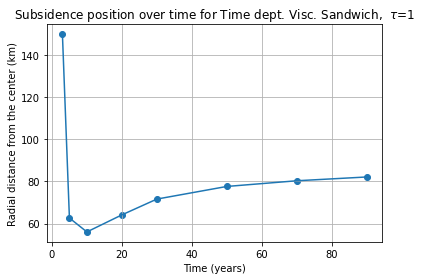

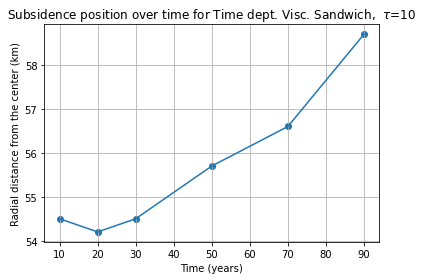

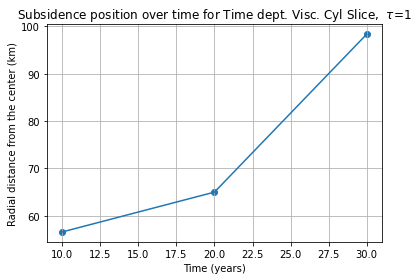

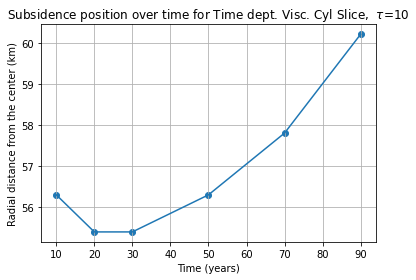

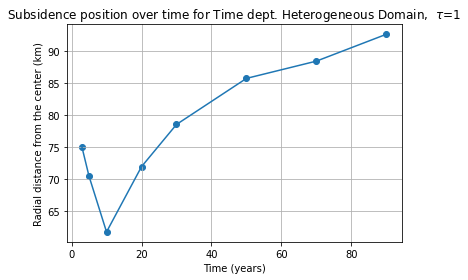

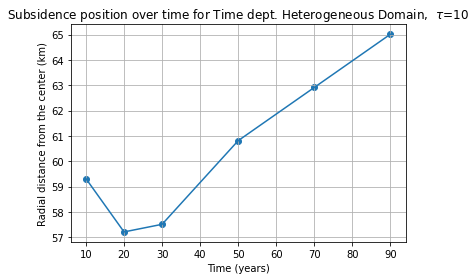

In [25]:
dt=1.0

time_steps = [20, 30, 50, 70, 90]
#surface_vert_disp_time("OneLayerViscoelastic", time_steps, 1, dt, check_sub=True, theta=None, save=False)
# surface_vert_disp_time("ViscoelasticLayer", time_steps, 10, dt, check_sub=True, theta=None, save=False)
# surface_vert_disp_time("ViscoelasticSandwich/10km", time_steps, 10, dt, check_sub=True, theta=None)
# surface_vert_disp_time("ViscoelasticSandwich/15km", time_steps, 10, dt, check_sub=True, save=False)
# surface_vert_disp_time("ViscoelasticCylinder/35km", time_steps, 10, dt, check_sub=True)
# surface_vert_disp_time("ViscoelasticCylinder/50km", time_steps, 10, dt, check_sub=True, save=False)
# surface_vert_disp_time("ViscoelasticCylinderSlice/35km", time_steps, 10, dt, check_sub=True)
# surface_vert_disp_time("ViscoelasticCylinderSlice/50km", time_steps, 10, dt, check_sub=True, save=False)
# surface_vert_disp_time("SMB/NoCyl", time_steps, 10, dt, plot_title_name="Layered Heterogeneous Model", check_sub=True, save=False)




time_steps = [1, 3, 5, 10, 20, 30, 50, 70, 90]

# surface_vert_disp_time("TimeDependentPressure/10yrSawtooth/ViscoelasticLayer", time_steps, 1, dt, plot_title_name="Time dept. Visc. Layer", check_sub=True)
# surface_vert_disp_time("TimeDependentPressure/10yrSawtooth/ViscoelasticSandwich", time_steps, 1, dt, plot_title_name="Time dept. Visc. Sand.", check_sub=True)
# surface_vert_disp_time("TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/35km", time_steps, 1, dt, plot_title_name="Time dept. Visc. Cyl. Slice, 35km", check_sub=True, theta=0.0)
# surface_vert_disp_time("TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/50km", time_steps, 1, dt, plot_title_name="Time dept. Visc. Cyl. Slice, 50km", check_sub=False, save=True)
# surface_vert_disp_time("TimeDependentPressure/10yrSawtooth/SMB/NoCyl", time_steps, 1, dt, plot_title_name="Time dept. Heterogeneous Domain", check_sub=False, save=True)


# time_steps = [0, 1, 2, 3,4 , 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90]

sub_over_time("TimeDependentPressure/10yrSawtooth/ViscoelasticSandwich", time_steps, 1, dt, plot_title_name="Time dept. Visc. Sandwich")
sub_over_time("TimeDependentPressure/10yrSawtooth/ViscoelasticSandwich", time_steps, 10, dt, plot_title_name="Time dept. Visc. Sandwich")

sub_over_time("TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/50km", time_steps, 1, dt, plot_title_name="Time dept. Visc. Cyl Slice")
sub_over_time("TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/50km", time_steps, 10, dt, plot_title_name="Time dept. Visc. Cyl Slice")

sub_over_time("TimeDependentPressure/10yrSawtooth/SMB/NoCyl", time_steps, 1, dt, plot_title_name="Time dept. Heterogeneous Domain")
sub_over_time("TimeDependentPressure/10yrSawtooth/SMB/NoCyl", time_steps, 10, dt, plot_title_name="Time dept. Heterogeneous Domain")

# sub_magnitude_time("TimeDependentPressure/10yrSawtooth/ViscoelasticSandwich", time_steps, 1, dt, plot_title_name="Time dept. Visc. Layer")
# sub_magnitude_time("TimeDependentPressure/10yrSawtooth/ViscoelasticSandwich", time_steps, 10, dt, plot_title_name="Time dept. Visc. Layer")

# sub_magnitude_time("TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/50km", time_steps, 1, dt, plot_title_name="Time dept. Visc. Cyl Slice")
# sub_magnitude_time("TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/50km", time_steps, 10, dt, plot_title_name="Time dept. Visc. Cyl Slice")

# sub_magnitude_time("TimeDependentPressure/10yrSawtooth/SMB/NoCyl", time_steps, 1, dt, plot_title_name="Time dept. Heterogeneous Domain")
# sub_magnitude_time("TimeDependentPressure/10yrSawtooth/SMB/NoCyl", time_steps, 10, dt, plot_title_name="Time dept. Heterogeneous Domain")




# find_characteristic_times("ViscoelasticCylinderSlice/35km", time_steps, 1, dt)
# find_characteristic_times("ViscoelasticCylinderSlice/50km", time_steps, 1, dt)
# find_characteristic_times("ViscoelasticSandwich/10km", time_steps, 1, dt)

# find_characteristic_times("ViscoelasticCylinderSlice/35km", time_steps, 10, dt)
# find_characteristic_times("ViscoelasticCylinderSlice/50km", time_steps, 10, dt)
# find_characteristic_times("ViscoelasticSandwich/10km", time_steps, 10, dt)

#displacement_velocity_plots("ViscoelasticSandwich/10km", time_steps, 1, dt)
#displacement_velocity_plots("ViscoelasticSandwich/15km", time_steps, 1, dt)
# displacement_velocity_plots("ViscoelasticCylinder/35km", time_steps, 1, dt)
# displacement_velocity_plots("ViscoelasticCylinder/50km", time_steps, 1, dt)
#displacement_velocity_plots("ViscoelasticCylinderSlice/35km", time_steps, 1, dt)
#displacement_velocity_plots("ViscoelasticCylinderSlice/50km", time_steps, 1, dt)
# displacement_velocity_plots("SMB/NoCyl", time_steps, 1, 1)
# displacement_velocity_plots("TimeDependentPressure/10yrSawtooth/ViscoelasticSandwich", time_steps, 1, dt, plot_title_name="Time dept. Visc. Sand.", save=True)
# displacement_velocity_plots("TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/35km", time_steps, 1, dt, plot_title_name="Time dept. Visc. Cyl. Slice, 35km", save=False)
# displacement_velocity_plots("TimeDependentPressure/10yrSawtooth/ViscoelasticCylinderSlice/50km", time_steps, 1, dt, plot_title_name="Time dept. Visc. Cyl. Slice, 50km", save=True)
# displacement_velocity_plots("TimeDependentPressure/10yrSawtooth/SMB/NoCyl", time_steps, 1, dt, plot_title_name="Time dept. Heterogeneous Domain", save=True)

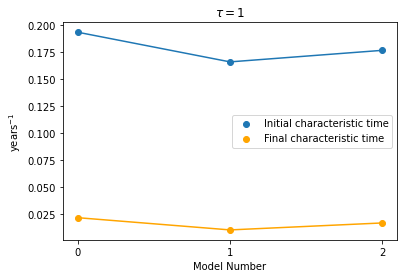

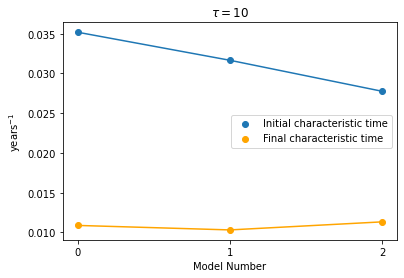

In [7]:
#Make characteristic time plots
#arrays are ordered Visc. Cyl. Slice 35km, 50km, Visc. Sandwich
model_numbers = [0,1,2]

char1_1yrRelax = np.asarray([-0.19366248456977347, -0.1661690558714919, -0.1768724719857525])
char2_1yrRelax = np.asarray([-0.02164136170543221, -0.010304666214620404, -0.016764497087745835])

char1_10yrRelax = np.asarray([-0.03518101460117117, -0.03165475479321771, -0.027757313620871485])
char2_10yrRelax = np.asarray([-0.010882447678199491, -0.01031756772304395, -0.011330481082008374])

fig, ax = plt.subplots()
ax.set_xlabel("Model Number")
ax.set_ylabel(r"years$^{-1}$")
ax.set_title(r"$\tau = 1$")
#ax.grid()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.scatter(model_numbers, char1_1yrRelax*-1, label="Initial characteristic time")
ax.plot(model_numbers, char1_1yrRelax*-1)

ax.scatter(model_numbers, char2_1yrRelax*-1, label="Final characteristic time", color="orange")
ax.plot(model_numbers, char2_1yrRelax*-1, color="orange")

ax.legend()
plt.savefig("../Figures/DecayConstantHoriz_relax1.png")

plt.show()




fig, ax = plt.subplots()
ax.set_xlabel("Model Number")
ax.set_ylabel(r"years$^{-1}$")
ax.set_title(r"$\tau = 10$")
#ax.grid()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.scatter(model_numbers, char1_10yrRelax*-1, label="Initial characteristic time")
ax.plot(model_numbers, char1_10yrRelax*-1)

ax.scatter(model_numbers, char2_10yrRelax*-1, label="Final characteristic time", color="orange")
ax.plot(model_numbers, char2_10yrRelax*-1, color="orange")

ax.legend(loc="center right")

plt.savefig("../Figures/DecayConstantHoriz_relax10.png")
plt.show()